# Gaussian Mixture Model

In [70]:
import sys
import torch
import numpy as np
import scipy.stats
from torch.nn import Softmax
from torch.autograd import Variable
from matplotlib import pyplot
%matplotlib inline

import pyro
from pyro.infer.kl_qp import KL_QP
from pyro.distributions import bernoulli, categorical, delta, diagnormal, dirichlet, gamma, normal
from pyro.util import ng_zeros, ng_ones

In [71]:
softmax = Softmax()

def softmax_1d(x):
    assert x.dim() == 1
    return softmax(x.unsqueeze(0)).squeeze(0)

assert torch.sum(softmax_1d(torch.Tensor([0.0, 0.0]))).data[0] == 1

## Dataset

Here is our tiny dataset. It has five points.

In [72]:
data = torch.Tensor([0, 1, 10, 11, 12])

## Maximum likelihood approach

Let's start by optimizing model parameters `ps`, `mu`, and `sigma`, rather than treating them as random variables with priors.

In [81]:
K = 2  # Fixed number of components.
z_values = np.array(range(K), dtype=np.int)

def model(data):
    # Global parameters.
    ps = softmax(pyro.param('pre_ps', Variable(torch.zeros(1, K), requires_grad=True)))
    mu = pyro.param('mu', Variable(torch.normal(torch.zeros(K), torch.ones(K)), requires_grad=True))
    sigma = pyro.param('sigma', Variable(torch.ones(1), requires_grad=True))

    # Local parameters.
    for i, datum in enumerate(data):
        # z = pyro.sample('z_{}'.format(i), categorical, ps, vs=z_values)[0]
        z = pyro.sample('z_{}'.format(i), bernoulli, ps[:,1])
        pyro.observe('x_{}'.format(i), diagnormal, datum, mu[z], sigma)

def guide(data):
    for i, datum in enumerate(data):
        p = softmax(pyro.param('pre_p_{}'.format(i), Variable(torch.zeros(1, K), requires_grad=True)))
        # pyro.sample('z_{}'.format(i), categorical, p, vs=z_values)
        pyro.sample('z_{}'.format(i), bernoulli, p[:,1])

In [82]:
ps = softmax(Variable(torch.zeros(1, K)))
c = pyro.distributions.Bernoulli(ps[:, 1])
list(c.support())

[Variable containing:
  0
 [torch.FloatTensor of size 1x1], Variable containing:
  1
 [torch.FloatTensor of size 1x1]]

We'd like to implement EM by summing rather than sampling on the line marked "SAMPLE".

In [83]:
optim_fct = pyro.optim(torch.optim.Adam, {'lr': 0.05})
inference = KL_QP(model, guide, optim_fct, num_particles=1, enum_discrete=True)

In [84]:
%pdb off
pyro.set_rng_seed(0)
pyro.get_param_store().clear()  # See https://github.com/uber/pyro/issues/175
iters = []
loss = []
for i in range(500):
    inference.step(data)
    if i % 10 == 0:
        iters.append(i)
        loss.append(inference.eval_objective(data))
        sys.stdout.write('.' if i % 800 else '\n')
        sys.stdout.flush()

Automatic pdb calling has been turned OFF


TypeError: type() takes exactly 2 arguments (1 given)

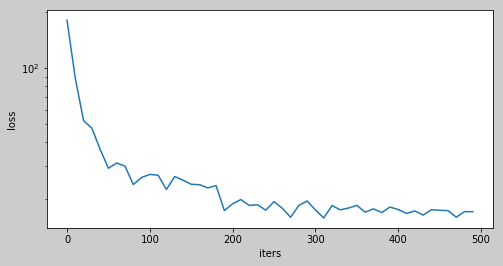

In [29]:
pyplot.figure(figsize=(8,4)).set_facecolor('#cccccc')
pyplot.plot(iters, loss)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')

In [100]:
ps = softmax_1d(pyro.param('pre_ps'))
mu = pyro.param('mu')
sigma = pyro.param('sigma')

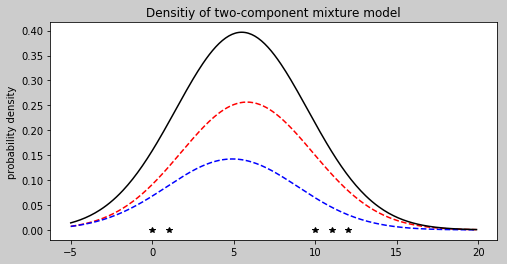

In [101]:
X = np.arange(-5,20,0.1)
Y1 = ps.data[0] * scipy.stats.norm.pdf((X - mu.data[0]) / sigma.data[0])
Y2 = ps.data[1] * scipy.stats.norm.pdf((X - mu.data[1]) / sigma.data[0])

pyplot.figure(figsize=(8, 4)).set_facecolor('#cccccc')
pyplot.plot(X, Y1, 'r--')
pyplot.plot(X, Y2, 'b--')
pyplot.plot(X, Y1 + Y2, 'k-')
pyplot.plot(data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density')

## Fully Bayesian aproach

Next we'll treat `ps`, `mu`, and `sigma` as random variables.

TODO